# Оптимизация процесса выбора региона для разработки нефтяных месторождений

## Введение

**Описание проекта:** Заказчик - компания по добыче нефти «ГлавРосГосНефть». Заказчику необходимо решить, в каком регионе бурить новые скважины. 

Шаги для выбора локации обычно такие:
1. Сбор характеристик для скважин в выбранном регионе: качество нефти и объём её запасов;
2. Строительство модель для предсказания объёма запасов в новых скважинах;
3. Выбор скважины с самыми высокими оценками значений;
4. Определение регион с максимальной суммарной прибылью отобранных скважин.

**Цель проекта:** На основании имеющихся данных определить наиболее прибыльный регион для строительства наиболее прибыльных скважин.

**Описание данных:**
В нашем распоряжении данные о скважинах в трех регионах, данные о скважинах из каждого хранятся в таблицах: `geo_data_0.csv`; `geo_data_1.csv`; `geo_data_2.csv`;

Признаки:
- `'id'` - Уникальный идентификатор скважины;
- `'f0'`, `'f1'`, `'f2'` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `'product'` - Объем запасов (тыс. баррелей);

**План работ:**
1. Загрузка и изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Обучение моделей МО для прогнозирования объема запасов нефти на основании входных признаков f0, f1, f2
5. Расчет и построение распределений прибыли от разработки запасов регионов, используя Bootstrap и моделей МО для определения лучших точек для строительства скважин
6. Оформление рекомендаций для Заказчика проекта и общего вывода

## Загрузка данных и первоначальное изучения

Загрузим датасеты и изучим информацию о них

In [1]:
#!pip install scikit-learn==1.5.2 -q
#!pip install phik

In [2]:
# Опционально: убираем все предупреждения
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Необходимые импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import phik

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import root_mean_squared_error


Bad key text.latex.preview in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.3/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/envs/practicum/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_qualit

In [4]:
# Считываем данные
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Первоначальное изучение данных

Посмотрим на первые 5 строк каждой таблицы и общую информацию о данных

In [5]:
# Функция для предварительного изучения данных
def df_overview(df):
    print(f'Регион {i}')
    display(df.head(5))
    print(df.info())
    print('\n')

In [6]:
# Список для хранения всех первоначальных таблиц, пригодится для первых этапов
df_list = [geo_data_0, geo_data_1, geo_data_2]
for i in range(len(df_list)):
    df_overview(df_list[i])

Регион 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Регион 1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Регион 2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None




### Общий вывод по Загрузке данных:
- Данные соответствуют описанию
- В каждом регионе предоставлено одинаковое количество строк с данными о скважинах
- В данных отсутствуют пропущенные значения
- Типы данных оптимальны

## Предобработка данных

Проверим, есть ли в данных явные дубликаты. Сначала проверим, все ли строки уникальны по `'id'`, а далее поместим `'id'` в индекс и проверим, есть ли строки с идентичными параметрами, но разными `'id'`. Такие строки не ведут к более точным предсказаниям модели и нас не интересут.

In [7]:
# Фиксация random_state
state = 42

In [8]:
# В одном цикле перебираем датафреймы, меняем id и ищем кол-во дубликатов
for i in range(len(df_list)):
    print(f'Регион {i}:\nКоличество дубликатов по id: {df_list[i].duplicated().sum()}')
    df_list[i].set_index('id', inplace=True)
    print(f'Количество дубликатов с уникальными id: {df_list[i].duplicated().sum()}\n')

Регион 0:
Количество дубликатов по id: 0
Количество дубликатов с уникальными id: 0

Регион 1:
Количество дубликатов по id: 0
Количество дубликатов с уникальными id: 0

Регион 2:
Количество дубликатов по id: 0
Количество дубликатов с уникальными id: 0



Явные дубликаты в данных отсутствуют, неявных быть не может, так как единственный строковый тип данных - `'id'`. Можно двигаться дальше.

### Вывод по предобработке данных:

- В данных отсутствуют дубликаты

## Исследовательский анализ данных

### Изучение распределений признаков

In [9]:
# Функция для более удобного отображения графиков
def display_feature_hist(df, number):
    for feature in df.columns:
        df[feature].hist(bins=25, legend=False, grid=True)
        plt.title(f'Распределение признака {feature} в Регионе {number}')
        if feature == 'product':
            plt.xlabel('Объем запасов, тыс.баррелей')
        else:
            plt.xlabel('Значение')
        plt.ylabel('Частота')
        plt.show()
        print(df[feature].describe())

### Регион 0

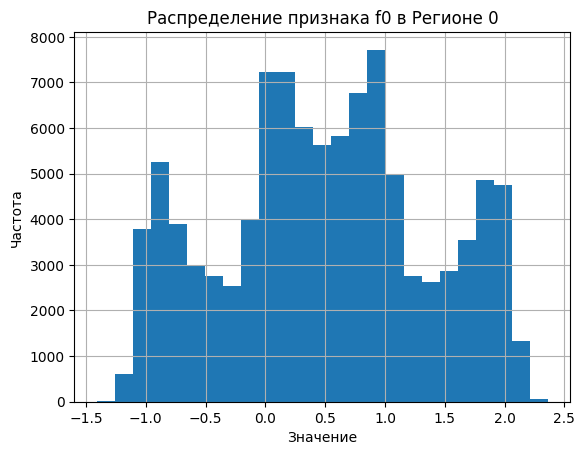

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


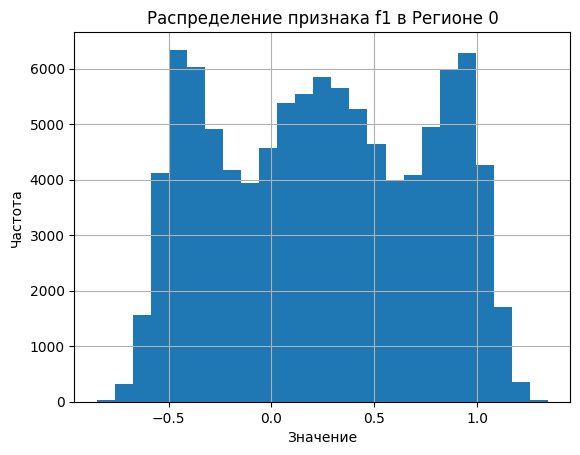

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


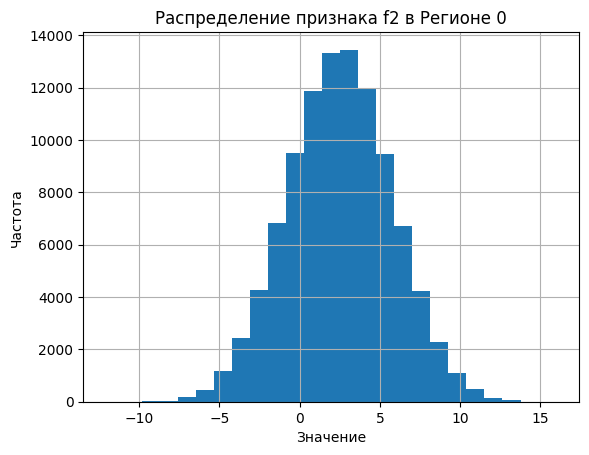

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


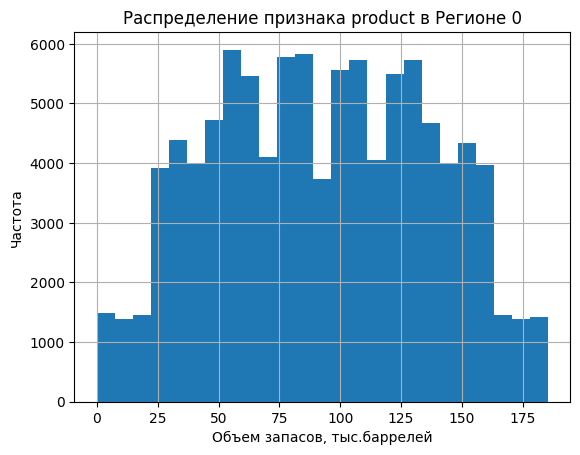

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


In [10]:
display_feature_hist(geo_data_0, 0)

**Интерпретация графиков:**
- Распределение f0 многовершинное: напоминает нормальное, но с множественными пиками: чуть больше среднего (оно равно 0.5) - 0 и 1, а также около минимального и максимального значения - в районе -1 и 2. Выбросы и аномальные значения отсутствуют.
- Распределение f1 напоминает нормальное, но с двумя экстремальными пиками: около минимального и максимального значения (-0.5 и 1). Среднее значение 0.25. Выбросы и аномальные значения отсутствуют.
- Распределение f2 нормальное, без аномалий. Среднее значение 2.5. Выбросы и аномалии отсутствуют.
- Распределение Объема запасов имеет форму нормального, без выбросов и аномальных значений. Среднее - 92, медиана 91.8 (почти совпадает со средним).

### Регион 1

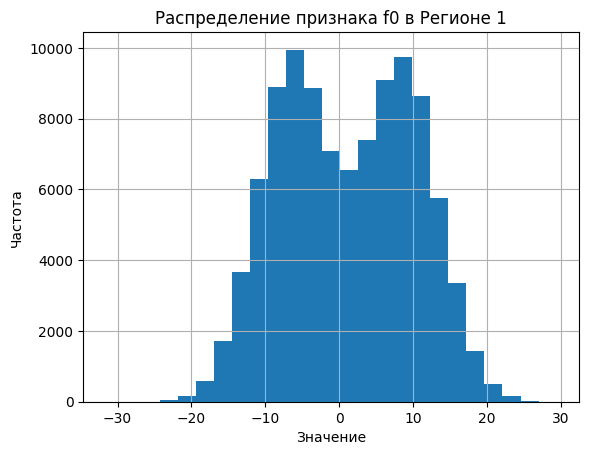

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


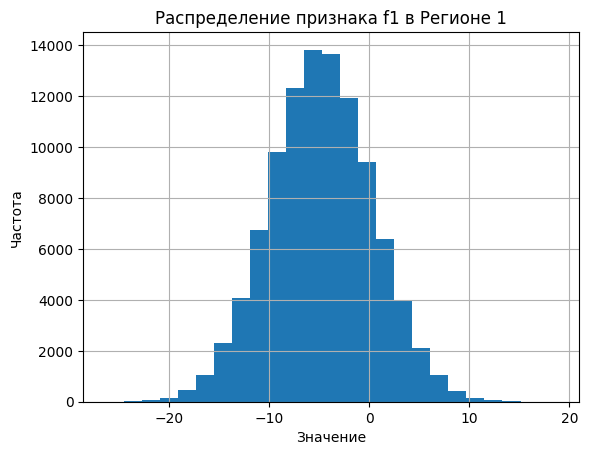

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


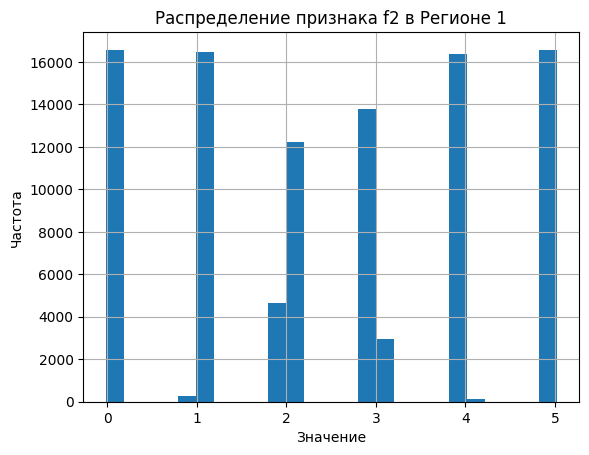

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


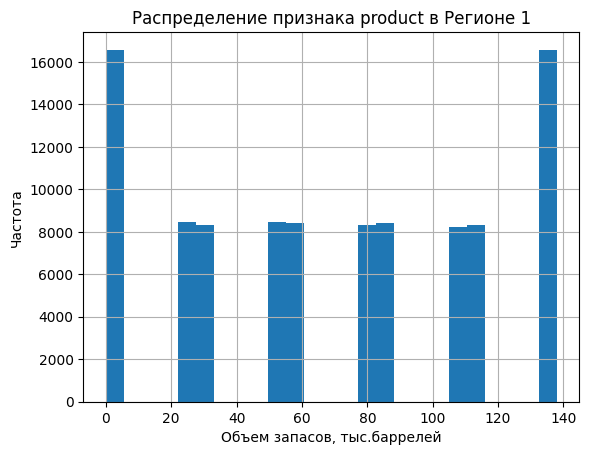

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


In [11]:
display_feature_hist(geo_data_1, 1)

**Интерпретация графиков:**
- Распределение f0 в напоминает бимодальное, но по общему контуру напоминает нормальное (чем дальше от среднего, тем реже более экстремальные значения) - есть пики около 5 и 9, среднее значение 1.14.
- Распределение f1 нормальное, со средним -4.8, медиана чуть больше -4.8.
- Признак f2 является дискретным, принимает значения, близкие к целочисленным - от 0 до 5, частота при этом у каждого значения примерно одинаковая.
- Распределение Объема запасов в регионе не имеет форму нормального распределения - значения похожи на дискретные, и делит все скважины на группы: Объем 0, объем 20-40, объем 40-60, объем 100-120, объем 130-140. При том, группы 20-40, 40-60 и 100-120 примерно равны по численности (чуть больше 8000), а группы "0" и "130+" более многочисленны и примерно равны между собой - частота около 16000 скважин.

### Регион 2

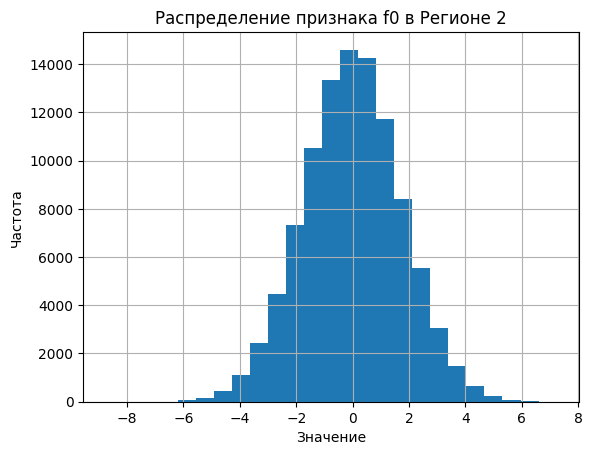

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


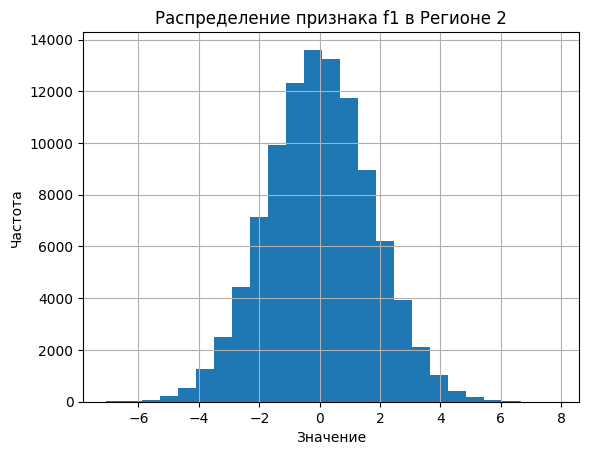

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


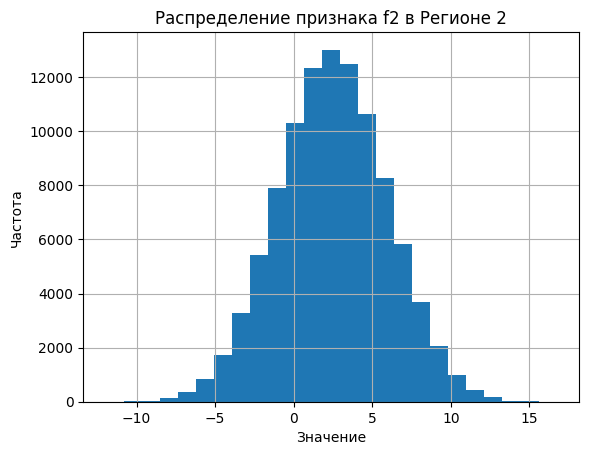

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


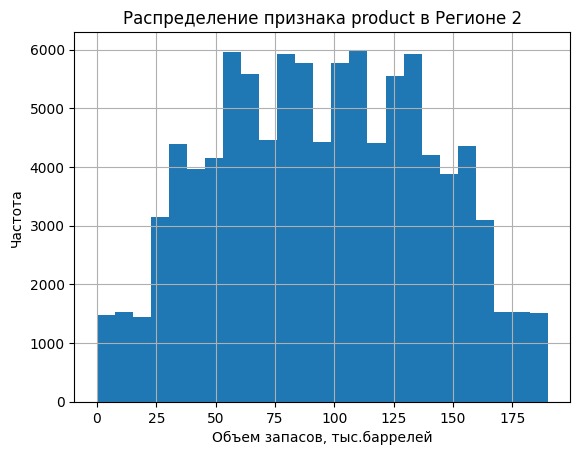

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


In [12]:
display_feature_hist(geo_data_2, 2)

**Интерпретация графиков:**
- Распределение f0 нормальное, стандартизированное. Среднее значение 0. Выбросы и аномалии отсутствуют
- Распределение f1 нормальное, стандартизированное. Среднее значение 0. Выбросы и аномалии отсутствуют
- Распределение f2 нормальное, среднее значение 2.5. Выбросы и аномалии отсутствуют.
- Распределение Объема запасов нормальное, среднее значение и медиана 95.

### Корреляционный анализ данных

Построим матрицы корреляций для всех таблиц, убедимся в отсутствии мультиколлинеарности. Для анализа будем использовать коэффициент корреляции phik, так как не все признаки распределены нормально.

In [13]:
# Список входных признаков. Сохраним его, далее он еще пригодится
features = ['f0', 'f1', 'f2']

In [14]:
# В функции использован аттрибут sample, так как 10000 строк обрабатываются слишком долго
def display_phik_heatmap(geo_data):
    matrix = geo_data.sample(1000, random_state=state).phik_matrix(interval_cols=features).round(2)
    plt.figure(figsize=(5,5))
    sns.heatmap(data=matrix, annot=True)
    plt.title('Матрица корреляций phik')
    plt.show()

#### Регион 0

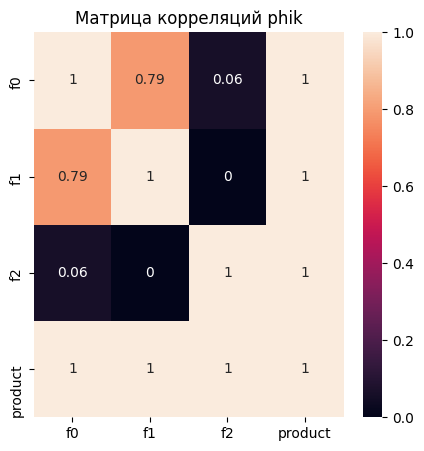

In [15]:
display_phik_heatmap(geo_data_0)

**Интерпретация тепловой карты:**
- Входные признаки сильно влияют на целевой
- Мультиколлинеарность отсутствует

#### Регион 1

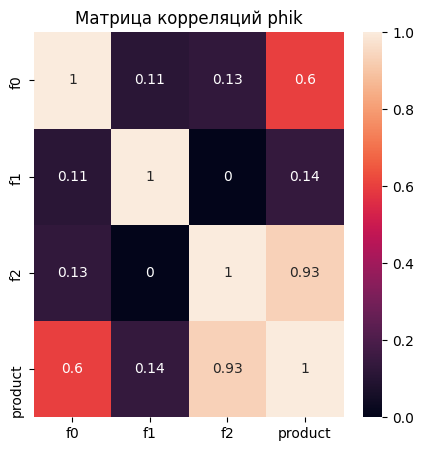

In [16]:
display_phik_heatmap(geo_data_1)

**Интерпретация тепловой карты:**
- f0 заметно влияет на целевой признак, f1 слабо, а f2 сильно
- Мультиколлинеарность отсутствует

#### Регион 2

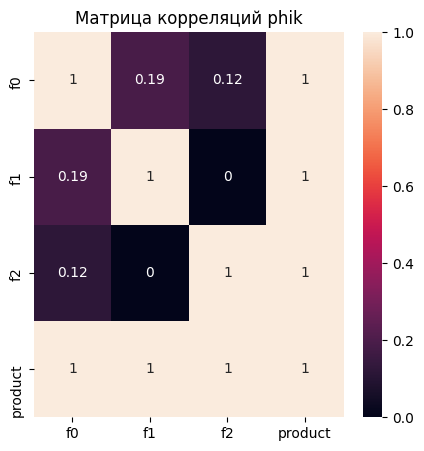

In [17]:
display_phik_heatmap(geo_data_2)

**Интерпретация тепловой карты:**
- Входные признаки сильно влияют на целевой
- Мультиколлинеарность отсутствует

### Вывод по исследовательскому анализу данных
- Почти все входные признаки сильно влияют на целевой признак
- Мультиколлинеарность входных признаков отсутствует
- Распределения признаков отличаются от региона к региону:

**Регион 0:**
- Распределение f0 многовершинное: напоминает нормальное, но с множественными пиками: чуть больше среднего (оно равно 0.5) - 0 и 1, а также около минимального и максимального значения - в районе -1 и 2. Выбросы и аномальные значения отсутствуют.
- Распределение f1 напоминает нормальное, но с двумя экстремальными пиками: около минимального и максимального значения (-0.5 и 1). Среднее значение 0.25. Выбросы и аномальные значения отсутствуют.
- Распределение f2 нормальное, без аномалий. Среднее значение 2.5. Выбросы и аномалии отсутствуют.
- Распределение Объема запасов имеет форму нормального, без выбросов и аномальных значений. Среднее - 92, медиана 91.8 (почти совпадает со средним).

**Регион 1:**
- Распределение f0 в напоминает бимодальное, но по общему контуру напоминает нормальное (чем дальше от среднего, тем реже более экстремальные значения) - есть пики около 5 и 9, среднее значение 1.14.
- Распределение f1 нормальное, со средним -4.8, медиана чуть больше -4.8.
- Признак f2 является дискретным, принимает значения, близкие к целочисленным - от 0 до 5, частота при этом у каждого значения примерно одинаковая.
- Распределение Объема запасов в регионе не имеет форму нормального распределения - значения похожи на дискретные, и делит все скважины на группы: Объем 0, объем 20-40, объем 40-60, объем 100-120, объем 130-140. При том, группы 20-40, 40-60 и 100-120 примерно равны по численности (чуть больше 8000), а группы "0" и "130+" более многочисленны и примерно равны между собой - частота около 16000 скважин.

**Регион 2:**
- Распределение f0 нормальное, стандартизированное. Среднее значение 0. Выбросы и аномалии отсутствуют
- Распределение f1 нормальное, стандартизированное. Среднее значение 0. Выбросы и аномалии отсутствуют
- Распределение f2 нормальное, среднее значение 2.5. Выбросы и аномалии отсутствуют.
- Распределение Объема запасов нормальное, среднее значение и медиана 95.

## Обучение моделей МО для прогнозирования объема сырья

Для обучения моделей будем использовать функцию

In [18]:
# Функция для обучения модели. 
# На вход принимает датафрейм, на котором будет проводиться обучение. 
# return_valid_sample - булев тип, при True функция, помимо модели, будет возвращать
# валидационную выборку (включая целевой признак)
def learn_model(geo_data, return_valid_sample=True):
    # Пайплайн для обработки признаков и обучения модели
    data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), features)
    ],
    remainder='passthrough'
    )

    final_pipeline = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )
    
    # Разделение на тренировочную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
    geo_data.drop('product', axis=1),
    geo_data['product'],
    test_size=0.25,
    random_state=state
    )
    
    # Обучение модели МО
    final_pipeline.fit(X_train, y_train)
    y_valid_pred = final_pipeline.predict(X_valid)

    # Вывод метрик
    print(f'Метрика RMSE на тренировочной выборке: {root_mean_squared_error(y_train, final_pipeline.predict(X_train))}')
    print(f'Метрика RMSE на валидационной выборке: {root_mean_squared_error(y_valid, y_valid_pred)}')
    print(f'Средний запас предсказанного сырья: {y_valid_pred.mean()}')
    
    # Объединение входных и целевого признака валидационной выборки
    if return_valid_sample==True:
        X_valid = X_valid.join(y_valid, how='inner')
        return final_pipeline, X_valid
    else:
        return final_pipeline

### Регион 0

In [19]:
reg_0_model, reg_0_valid_sample = learn_model(geo_data_0)

Метрика RMSE на тренировочной выборке: 37.67049903536212
Метрика RMSE на валидационной выборке: 37.756600350261685
Средний запас предсказанного сырья: 92.39879990657768


Модель обучена, причем предсказания модели достаточно точные (среднее значение объема сырья - 92, предсказание модели на валидационной выборке - 92.38). Корень средней квадратичной ошибки - 37.7.

### Регион 1

In [20]:
reg_1_model, reg_1_valid_sample = learn_model(geo_data_1)

Метрика RMSE на тренировочной выборке: 0.8904196385265012
Метрика RMSE на валидационной выборке: 0.8902801001028815
Средний запас предсказанного сырья: 68.7128780391376


Модель предсказыват достаточно точно - корень средней квадратичной ошибки меньше единицы: 0.89 на валидационной выборке, средний запас предсказанного сырья на валидационной выборке 68.7 - показатель почти совпадает со средним значением на всех данных.

Модель значительно точнее, чем модель для региона 0. В то время, как средний предсказанный запас - меньше, чем в регионе 0 (68 против 92)

### Регион 2

In [21]:
reg_2_model, reg_2_valid_sample = learn_model(geo_data_2)

Метрика RMSE на тренировочной выборке: 40.025181468019824
Метрика RMSE на валидационной выборке: 40.145872311342174
Средний запас предсказанного сырья: 94.77102387765936


Показатели схожи с Регионом 0: модель чуть сильнее ошибается RMSE (40 против 37), но средний запас сырья больше (95 против 92).

### Анализ результатов

- Модели для Регионов 0 и 2 демонстрируют похожие результаты: Регион 0 - корень ксреднеквадратичной ошибки равен 37.7, среднее значение объема запасов - 92. Регион 2 - корень ксреднеквадратичной ошибки равен 40.1, среднее значение запасов - 95.
- Модель для Региона 1 демонстрирует более стабильный результат - корень среднеквадратичной ошибки меньше единицы, это говорит, что модель **очень** точна. Но средний уровень запасов в регионе значительно ниже - среднее значение объема нефти 68.9 тысяч баррелей, это примерно на четверть меньше, чем в регионах 0 и 2.

## Подготовка к расчету прибыли

Найдем, каким объемом сырья должно обладать месторождения, чтобы быть безубыточным (выручка больше или равна затратам). Для этого найдем значение, при котором затраты на строительство скважины на месторождении равны выручке от продажи всей нефти из месторождения. Нас интересуют значения объема сырья, **которые больше этого числа**.

Так как бюджет на разработку равен 10 млрд., а построить необходимо 200 скважин, бюджет разработки одной скважины в среднем 50 млн. Будем отталкиваться от таких затрат при расчетах.

### Подготовка данных для расчета прибыли

Для расчета прибыли с помощью функции, необходимы дополнительные переменные. Создадим их в следующем шаге.

In [22]:
# Переменная хранит список с моделями МО, которые обучены прогнозировать 
# объем продукции в конкретном регионе. Номер региона должен строго совпадать
# с индексом модели в этом списке. 
estimators_list = [reg_0_model, reg_1_model, reg_2_model]

# Список для хранения валидационных выборок. Аналогично списку моделей, номер региона должен совпадать
# с индексом соответствующей выборки
valid_samples_list = [reg_0_valid_sample, reg_1_valid_sample, reg_2_valid_sample]

# Переменные для дальнейших расчетов
total_costs_in_millions = 10000
barrel_price_in_millions = 0.45
wells_to_build_number = 200
locations_to_explore_number = 500

### Расчет объема сырья для безубыточности

In [23]:
# Добавим к результату деления 0.01, так как результат деления - периодическая дробь
break_even_product = round(total_costs_in_millions/wells_to_build_number/barrel_price_in_millions + 0.01, 2)
print(f'Искомое значение объема нефти в 1 месторождении для безубыточности: {break_even_product} тыс. баррелей')

Искомое значение объема нефти в 1 месторождении для безубыточности: 111.12 тыс. баррелей


### Вывод:
- Во всех трех регионах средний показатель объема запасов меньше, чем объем для безубыточной разработки скважины;
- В Регионах 0 и 2 111.12 тыс. баррелей попадает в 3-й квартиль, то есть в этих регионах 25% месторождений, которые хранят наибольшее количество нефти, есть эти значения. В то время, как в Регионе 1 это значение не попадает в 3-й квартиль, то есть таких скважин менее 25%.
- Созданы списки, которые позволяют более оптимально работать функции для расчета прибыли

## Рассчет прибыли по регионам

Рассчитаем прибыль по регионам на основании предсказаний разработанных нами моделей. Для этого, случайным образом выберем 500 точек для исследования, из них по результатам прогноза объема запасов, отберем 200 лучших. Далее просуммируем запасы этих точек, вычислим выручку от продажи нефти и прибыль от разработки всех месторождений. 

Для имитации исследования 500 точек, будем использовать Бутстреп на основании валидационной выборки.

**Легенда для интерпретации графиков:** Зеленые границы показывают 95% доверительный интервал, синяя пунктирная линия - среднее значение прибыли, а красный пунктир показывает 0 - левее этой линии компания получает убыток.

In [24]:
# Функция для построения распределения прибыли на основании Bootstrap, принимает на вход номер региона
# возвращает список (распределение) значений возможной прибыли от разработки региона.
# display_hist - булев тип, при True (по умолчанию) сразу выводит гистограмму распределения
# display_hist - булев тип, при True (по умолчанию) выводит показатели (дов.интервал, риск убытков)
sample_state = np.random.RandomState(12345)


def calculate_region_profit(region_number, display_hist=True, display_info=True):
    profit_distr = []
    for i in range(1000):
        sample = valid_samples_list[region_number].sample(
            n=locations_to_explore_number, replace=True, random_state=sample_state)
        sample['predicted_product'] = estimators_list[region_number].predict(
            sample)
        sample = sample.sort_values(
            by='predicted_product').tail(wells_to_build_number)
        profit = (sample['product'].sum() *
                  barrel_price_in_millions) - total_costs_in_millions
        profit_distr.append(profit)

    # Технические преобразования для визуализации
    profit_distr = pd.Series(profit_distr)
    lower_quantile = np.quantile(profit_distr, 0.025)
    upper_quantile = np.quantile(profit_distr, 0.975)

    # Визуализация
    if display_hist == True:
        profit_distr.hist(bins=20)
        plt.title(
            f'Распределение прибыли от разработки Региона {region_number}')
        plt.xlabel('Прибыль, млн.')
        plt.ylabel('Частота')
        plt.axvline(x=profit_distr.mean(), color='b', linestyle='--')
        plt.axvline(x=0, color='red', linestyle='--')
        plt.axvspan(xmin=lower_quantile, xmax=upper_quantile,
                    facecolor='g', alpha=0.3)
        plt.show()

    # Отображение показателей
    if display_info == True:
        print(
            f'Доверительный интервал 95%: ({round(lower_quantile, 2)};{round(upper_quantile, 2)})')
        print(f'Средняя прибыль: {round(profit_distr.mean(), 2)} млн.')
        loss_share = st.percentileofscore(profit_distr, 0)
        print(f'Риск убытков: {loss_share}%')

    return profit_distr

### Регион 0

Построим распределение прибыли с помощью нашей функции.

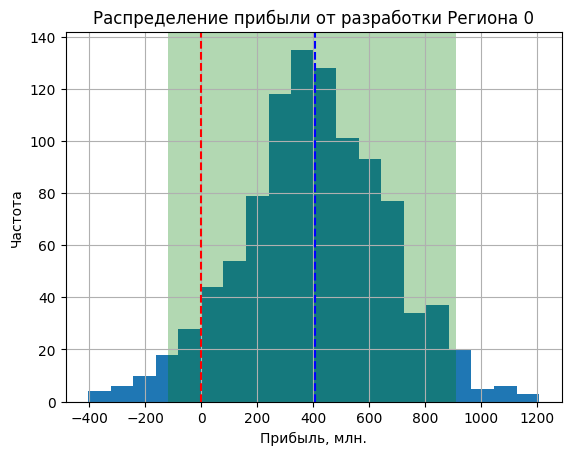

Доверительный интервал 95%: (-117.74;911.74)
Средняя прибыль: 406.28 млн.
Риск убытков: 6.7%


In [25]:
reg_0_distr = calculate_region_profit(0)

#### Анализ графика
- Доверительный интервал прибыли - от -117.74 мл. до 911.74 млн. Обратим внимание, что в доверительный интервал попадают отрицательные значения(от -117.74 до 0), а по условию задачи нам нужен регион, в котором отрицательные значения прибыли не должны попадать в доверительный интервал)
- Риск убытков выше, чем в условии (необходимо найти регион с риском убытков менее 2.5%), 6.7 - слишком высокий риск.
- Средняя прибыль равна 406 млн.

### Регион 1

Построим распределение прибыли с помощью нашей функции.

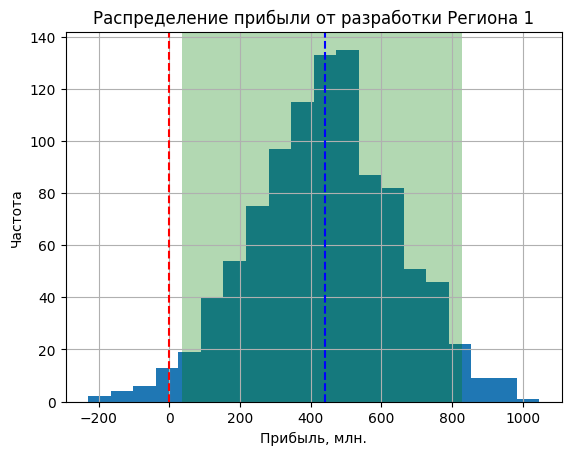

Доверительный интервал 95%: (35.73;828.01)
Средняя прибыль: 441.5 млн.
Риск убытков: 1.6%


In [26]:
reg_1_distr = calculate_region_profit(1)

#### Анализ графика
- Доверительный интервал прибыли - от 35.73 до 828.01 млн. 
- Риск убытков всего 1.6%, отрицательные значения не попали в доверительный интервал модели, этот регион нам подходит.
- Средняя прибыль 441.5 млн., неплохой показатель относительно Региона 0

### Регион 2

Построим распределение прибыли с помощью нашей функции.

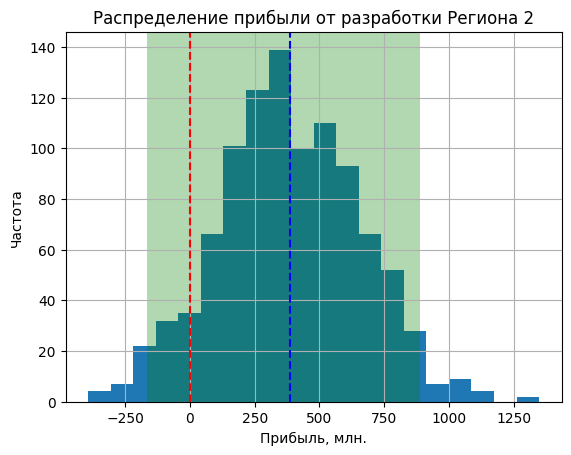

Доверительный интервал 95%: (-164.79;888.21)
Средняя прибыль: 385.21 млн.
Риск убытков: 7.800000000000001%


In [27]:
reg_2_distr = calculate_region_profit(2)

#### Анализ графика
- Доверительный интервал прибыли - от -164.79 до 888.21 млн. Обратим внимание, что в доверительный интервал попали отрицательные значения (от -164.79 до 0)
- Риск убытков составляет 7.8%, что является самым высоким показателем среди трех обозреваемых регионов. 
- Средняя прибыль равна 385.21 млн., что является самым низким показателем среди всех регионов.

### Вывод по расчету прибыли
- С помощью процедуры Bootstrap составлены распределения прибыли от разработки каждого из регионов (при выборе 200 лучших точек по предсказанию наших моделей МО из 500 исследуемых), получены 95%-е доверительные интервалы прибыли, а также средние значения и значения риска убытков по каждому из регионов.
- Лучший результат показал Регион 1. Его доверительный интервал прибыли - от 35.73 до 828.01 млн. Риск убытков всего 1.6% (это самый низкий показатель), отрицательные значения прибыли не попали в доверительный интервал модели. Средняя прибыль 441.5 млн., это лучший показатель среди трех обозреваемых регионов. 

### Рекомендация
Рекомендуем приступить к разработке месторождений в Регионе 1, так как этот регион является лучшим по всем показателям.

## Общий вывод по проекту
- Проведена загрузка данных, их предобработка и исследовательский анализ
- Для каждого региона обучены модели машинного обучения, которые позволяют на основании трех входных признаков спрогнозировать количество запасов сырья в исследуемой точке
- С помощью процедуры Bootstrap составлены распределения прибыли от разработки каждого из регионов (при выборе 200 лучших точек по предсказанию наших моделей МО из 500 исследуемых), получены 95%-е доверительные интервалы прибыли, а также средние значения и значения риска убытков по каждому из регионов.
- Для заказчика сформирована рекомендация по выбору региона: **Разработку необходимо начинать в Регионе 1, так как он является лучшим по всем показателям: Доверительный интервал прибыли - от 35.73 до 828.01 млн. Риск убытков всего 1.6%, отрицательные значения не попали в доверительный интервал модели.Средняя прибыль 441.5 млн.**